In [1]:
!pwd

/home/cellatlas/biol-paper/GBP_2024/notebooks


In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import anndata
from ec.utils import read_markers_txt
from collections import defaultdict
from sklearn.neighbors import kneighbors_graph
import random
from scipy.stats import zscore

def nd(arr):
    return np.asarray(arr).reshape(-1)

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
organ = 'testis'
home = '/home/cellatlas/human/data'
data = f'{home}/{organ}'
markers_path = '../files/testis_markers.other.txt'

In [4]:
observations = ['GSM4486714',
 'GSM3402080',
 'GSM2928381',
 'GSM3526586',
 'GSM2928378',
 'GSM3526585',
 'GSM3526584',
 'GSM3402078',
 'GSM2928382',
 'GSM3526590',
 'GSM2928379',
 'GSM2928377',
 'GSM3526589',
 'GSM4486715',
 'GSM3052921',
 'GSM3052919',
 'GSM3302525',
 'GSM3526588',
 'GSM2928380',
 'GSM2928384',
 'GSM3302524',
 'GSM3526583',
 'GSM3526587',
 'GSM4486716',
 'GSM3732871']

In [21]:
results_rank = []
results_expression = []
no_samples=0
for obs in tqdm(observations):
    try:
        mx_assignments_rank = pd.read_csv(f'../files/mx_testis_assignments/{obs}/assignments_rank_mx.tsv', sep = '\t')
        mx_assignments_rank = mx_assignments_rank.rename(columns = {'Unnamed: 0': 'cell'})
        mx_assignments_rank['observation'] = obs

        mx_assignments_expression = pd.read_csv(f'../files/mx_testis_assignments/{obs}/assignments_expression_mx.txt', sep = '\t')
        mx_assignments_expression = mx_assignments_expression.rename(columns = {'Unnamed: 0': 'cell'})
        mx_assignments_expression['observation'] = obs        

        # Add to list
        results_rank.append(mx_assignments_rank)
        results_expression.append(mx_assignments_expression)
        no_samples +=1
    except:
        continue
# Concatenate results
results_rank_df = pd.concat(results_rank)
results_expression_df = pd.concat(results_expression)
print(no_samples)

100%|██████████| 25/25 [00:09<00:00,  2.75it/s]


25


## Marker expression analysis

In [24]:
# Read markers.txt
markers_dict = defaultdict(list)
read_markers_txt(markers_path, markers_dict)
    
    
celltypes = list(markers_dict.keys())    
celltypes_no_other = list(markers_dict.keys())
celltypes_no_other.remove('Other') 

In [25]:
df_rank_mx = results_rank_df.groupby('label').mean()
df_expression_mx = results_expression_df.groupby('label').mean()

rank_markers_txt = df_rank_mx.columns[2:-15] ### CHECK NUMBER
expression_markers_txt = df_rank_mx.columns[2:-15] ### CHECK NUMBER


# Get expression levels by rank assignment
results_expression_df['rank_label'] = results_rank_df['label']
df_rankexpression_mx = results_expression_df.groupby('rank_label').mean()

In [26]:
ct_names_dict = {"RoundSpermatid": "Round Spermatid",
 "Elongating": "Elongating Spermatid",
 "f-Pericyte": "Fibroblastic Pericyte",
 "m-Pericyte": "Muscular Pericyte",
 "Tcell" :"T-cell",
 "ImmLeydig": "Immature Leydig", 'other': 'Other',
 # these cell types remain the same
 'Macrophage': 'Macrophage', 'Endothelial':'Endothelial',
 'Myoid': 'Myoid', 'Spermatogonia': 'Spermatogonia',
 'Spermatocyte': 'Spermatocyte', 'Other': 'Other', }

order = ["Macrophage","Endothelial", "Immature Leydig", "T-cell", "Myoid",
         "Muscular Pericyte",
        "Spermatogonia",  "Spermatocyte", "Round Spermatid",
         "Elongating Spermatid"]

order_old = ["Macrophage","Endothelial", "ImmLeydig", "Tcell", "Myoid",
         "m-Pericyte",
        "Spermatogonia",  "Spermatocyte", "RoundSpermatid",
         "Elongating"]

In [27]:
df = df_rankexpression_mx

genes_df = df.iloc[:,2:-12].drop('Other', axis = 0)

zscore_genes = zscore(genes_df, axis =0)
zscore_df = pd.DataFrame(zscore_genes)
zscore_df.columns = genes_df.columns
zscore_df.index = genes_df.index
zscore_df = zscore_df.reindex(order_old)
#zscore_df.index = [ct_names_dict[c] for c in zscore_df.index]

In [28]:
ordered_markers = []
for ct in zscore_df.index:
    ordered_markers.extend(markers_dict[ct])

In [29]:
zscore_df = zscore_df.T.reindex(ordered_markers).T

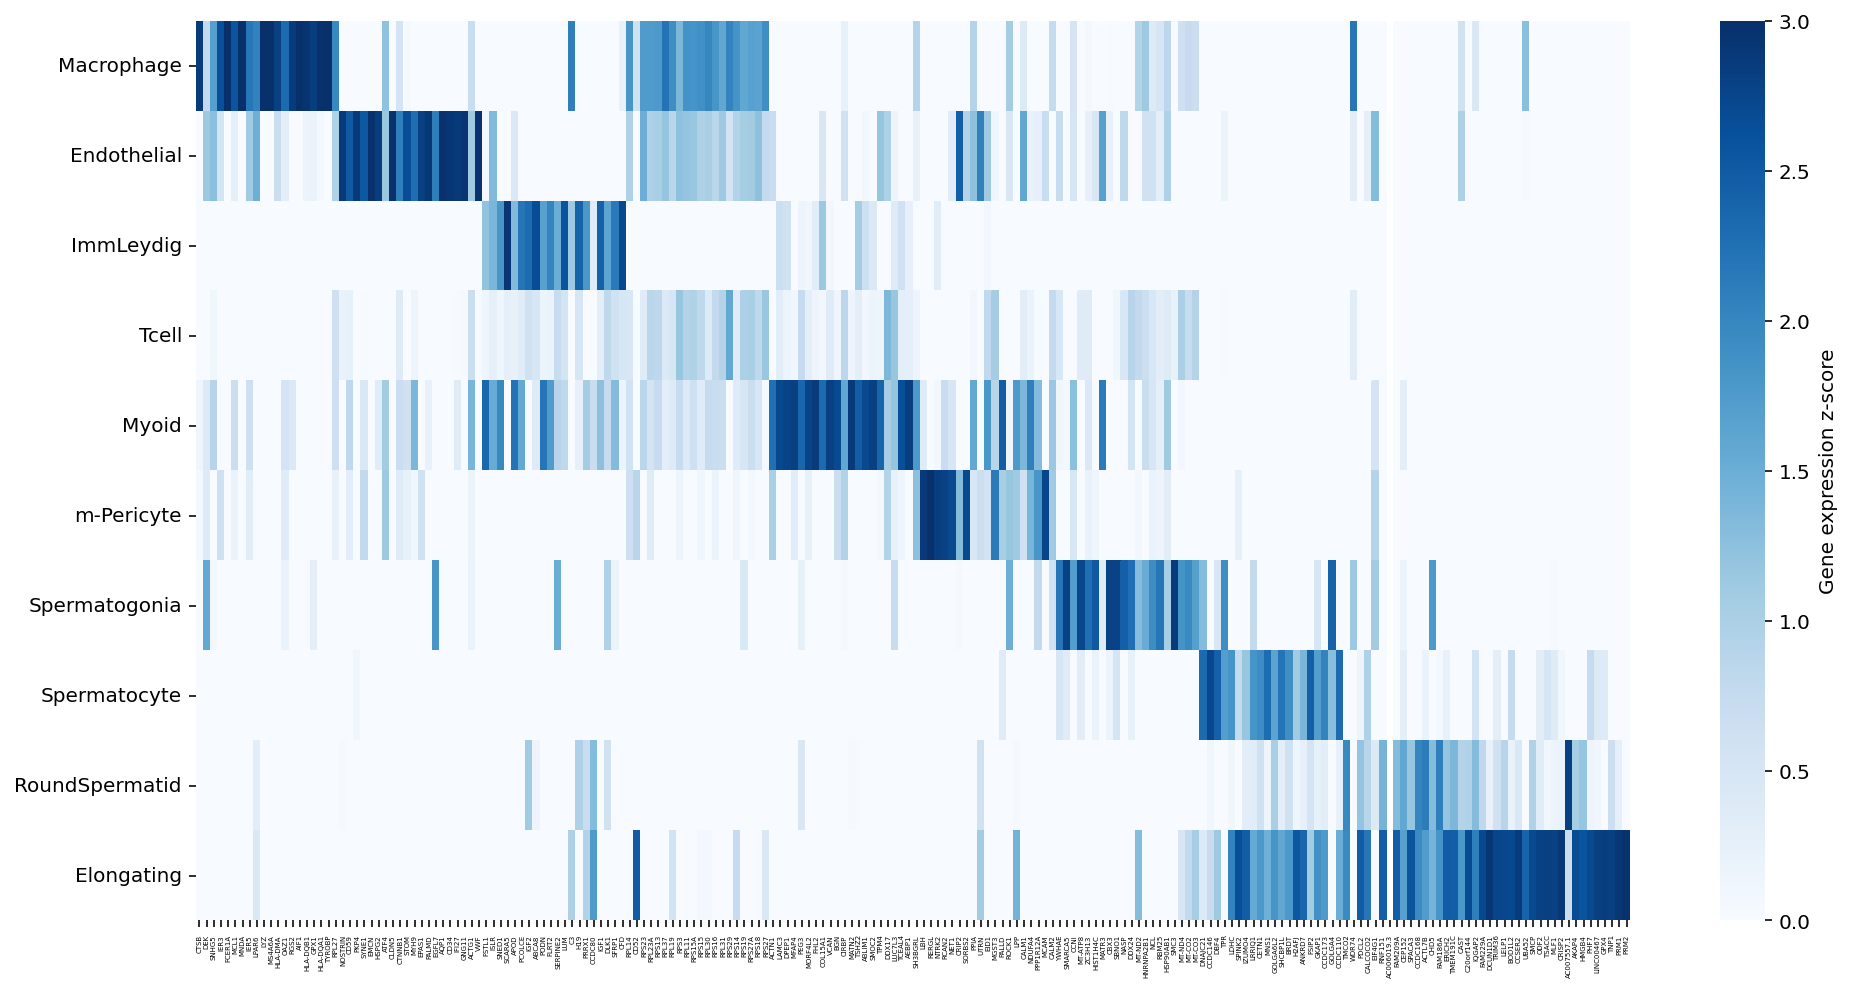

In [30]:
fig, ax = plt.subplots(figsize = (14,7))
sns.heatmap(zscore_df, cmap = 'Blues', 
            vmin = 0, vmax = 3, center = 1.5, xticklabels=zscore_df.columns, ax=ax, cbar_kws={'label': 'Gene expression z-score'})

ax.tick_params(axis='x', rotation=90, labelsize = 3.5)

ax.set_ylabel('')
plt.tight_layout()


## Concordex

In [31]:
from scipy import stats
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import random, csr_matrix
from scipy.cluster.hierarchy import single
from scipy.spatial.distance import pdist

from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import default_rng, choice

In [32]:
results_expression_no_other = results_expression_df.query('rank_label != "Other"')
results_expression_no_other = results_expression_no_other.sort_values(by='rank_label')
mtx = results_expression_no_other.iloc[:,4:-14].fillna(0)

In [33]:
graph = kneighbors_graph(csr_matrix(mtx.to_numpy()), 20, mode="connectivity", include_self=False)


In [34]:
graph

<118960x118960 sparse matrix of type '<class 'numpy.float64'>'
	with 2379200 stored elements in Compressed Sparse Row format>

In [35]:
labels = results_expression_no_other['rank_label'].values

In [36]:
def concordex_map_full(x, labels, k=20, cluster_rows=False):
    """
    Arguments
    ---------
    x: array
        The square binary connectivity matrix, typically generated from output
        of a k-nearest neighbor algorithm. Assumes sum of each row = k.
    labels: 1D array
        Labels corresponding to each column of x
    k: int
        Default 20. Number of neighbors 
    cluster_rows: bool
        Default False. Determines if rows are clustered in the output. May
        take considerably longer to run if True. See time complexity details
        in `scipy.cluster.hierarchy.linkage`
        
    Returns
    -------
    X: array
        Dimension  correspond to the number of cells (rows)
        and the number of unique labels (columns). 
    order: 
        1D array to determine how columns are ordered in X
    """
    
    n, _ = x.shape
    
    _, neighbors_loc = x.nonzero()
    neighbors_loc = np.array_split(neighbors_loc, n)
    
    # Fails if labels is not a np.array()
    labels = np.array(labels)
    labels_uniq = np.unique(labels)
    
    # Generate output in 2 steps for readability
    counters = [Counter(labels[inds]) for inds in neighbors_loc]
    
    out = np.array([
        itemgetter(*labels_uniq)(c)
         for c in counters
     ])
    
    if (cluster_rows):
        y = pdist(out)
        Z = single(y)
        Z = Z[:, range(2)].reshape(-1)
        
        inds = np.where(Z < n)
        row_order = np.array(Z[inds], dtype=np.int64)
        
        out = out[row_order,:]
        
    return out/k, labels_uniq

In [37]:
mtx_frac, col_order = concordex_map_full(graph, labels)

In [38]:
labels_uniq = np.unique(labels)

In [39]:
mtx_frac_df = pd.DataFrame(mtx_frac)
mtx_frac_df.columns = labels_uniq
mtx_frac_df = mtx_frac_df * 100

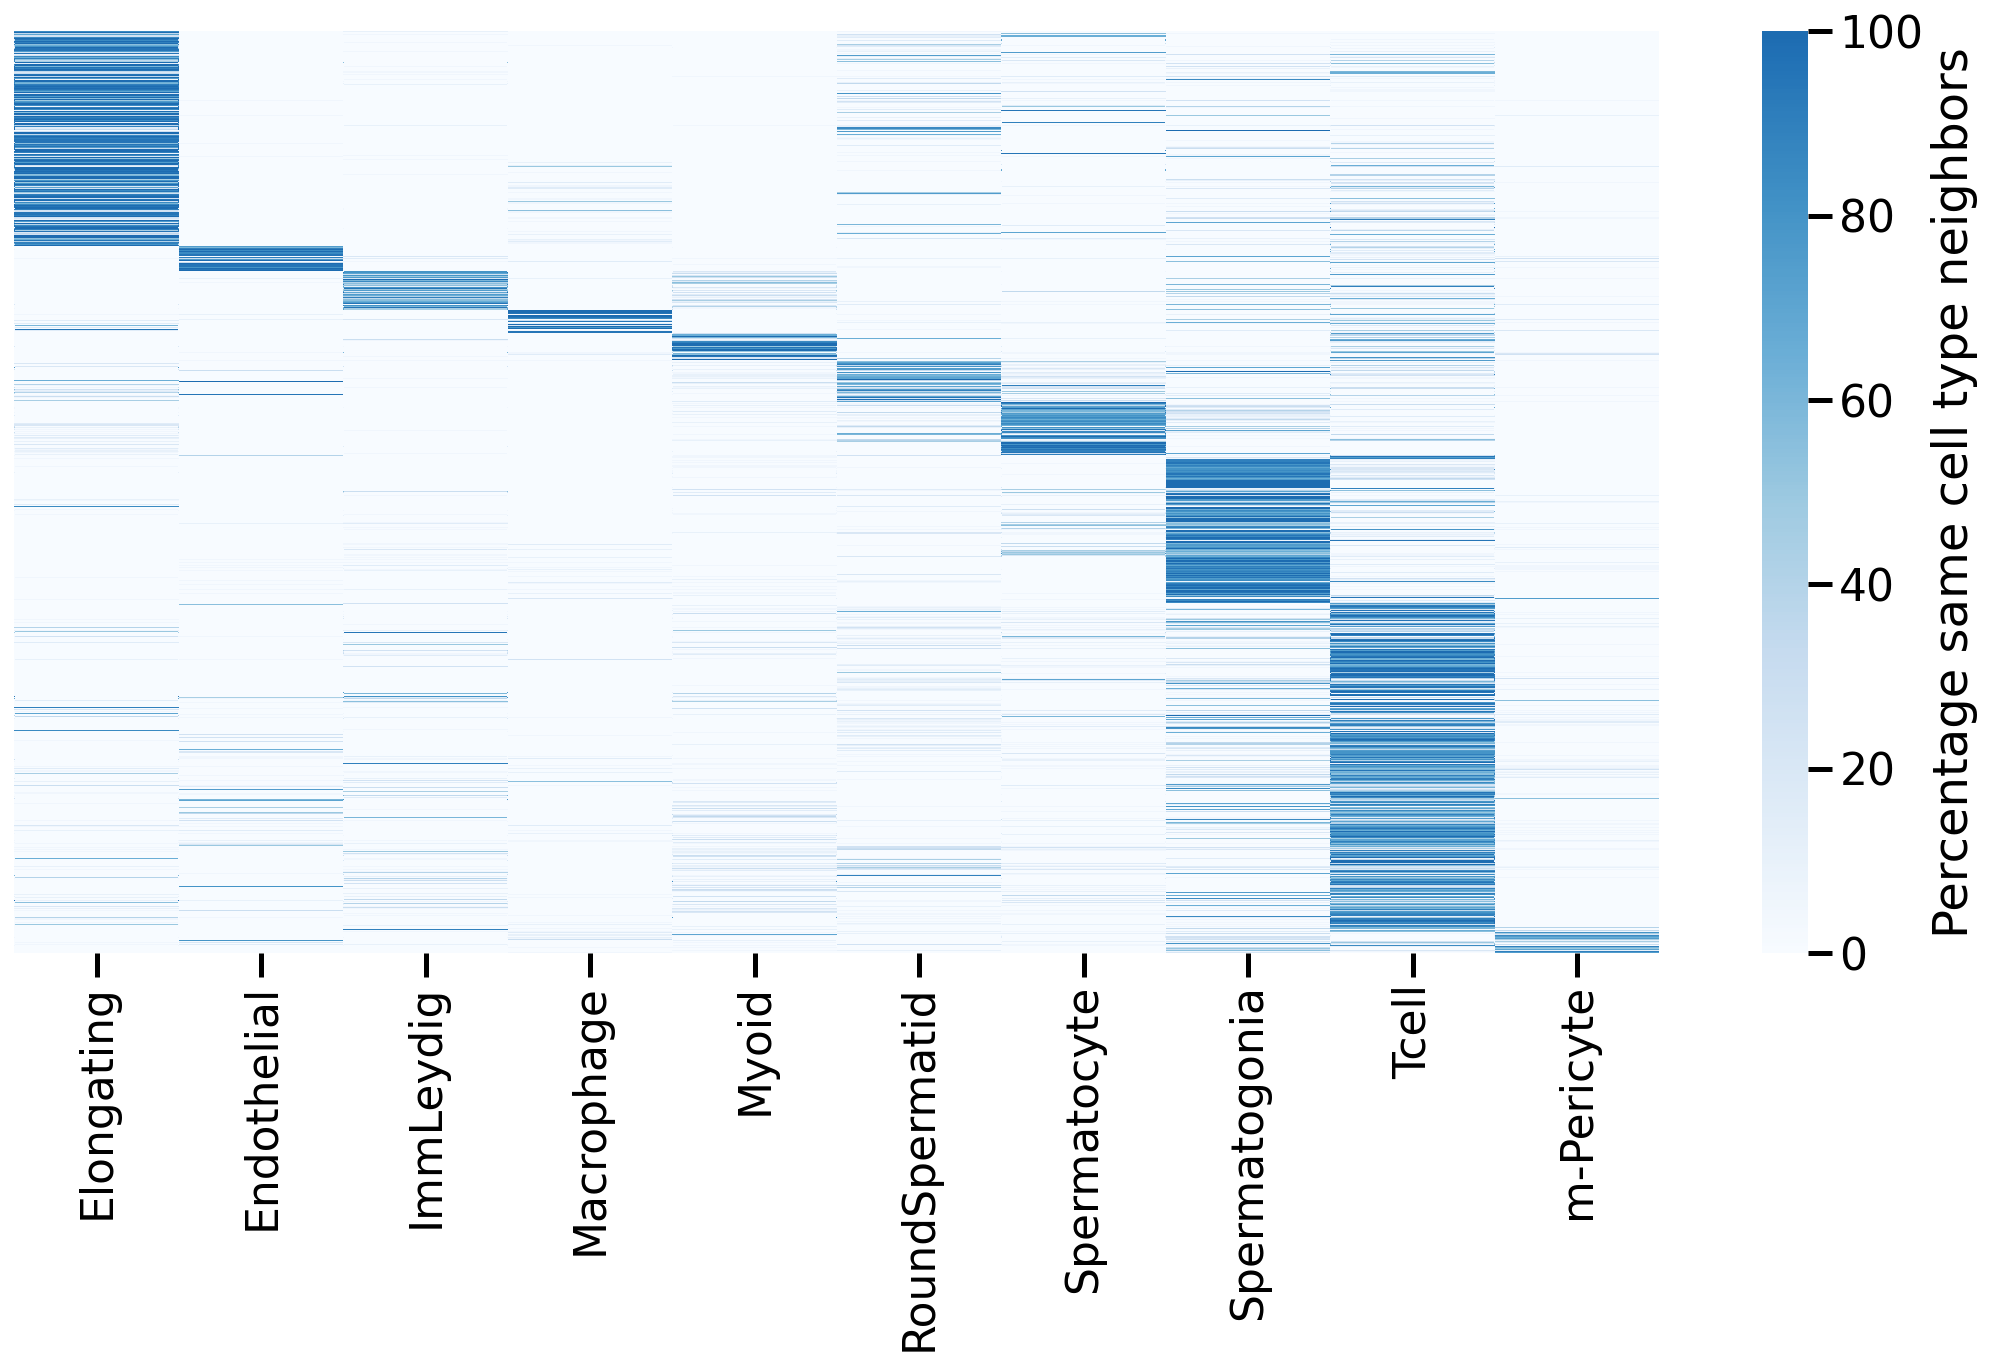

In [40]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(mtx_frac_df, cmap = "Blues", center = 65, cbar_kws={'label': 'Percentage same cell type neighbors'})
ax.yaxis.set_tick_params(labelleft=False)
plt.tick_params(left = False)
plt.tight_layout()
!mkdir -p figures
plt.savefig('figures/fig_2e.png')